In [163]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
#plt.style.use('fivethirtyeight')

In [164]:
recession_vs_yield = pd.read_csv('data/preprocessed_2.csv', index_col = 'Date')
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))


#Generate the different features
data_mean = recession_vs_yield.resample('Q-JAN', convention='end').agg('mean')
data_mean['USREC'] = data_mean['USREC'].apply(lambda x: 1 if x > 0 else 0)
data_std = recession_vs_yield.resample('Q-JAN', convention='end').agg('std').drop(columns = ['USREC'])
data_split = recession_vs_yield.resample('Q-JAN', convention='end').agg('max') - recession_vs_yield.resample('Q-JAN', convention='end').agg('min')
data_split = data_split.drop(columns = ['USREC']).add_suffix('_split')

#Merge them features
data = pd.merge_asof(data_mean,data_std, left_index = True, right_index = True, suffixes = ('_mean','_std'))
data = pd.merge_asof(data,data_split, left_index = True, right_index = True)
data = data.iloc[1:-1 , :]
data['USREC'] = data['USREC'].shift(periods = -1)
data = data.iloc[:-1,:]

In [165]:
data.corr()['USREC'].sort_values(ascending=False)

USREC                        1.000000
Value_3mon_std               0.394093
Value_3mon_split             0.387935
spread_std                   0.375029
Bad time to buy_mean         0.373564
spread_split                 0.366512
Value_3mon_mean              0.298457
Good time to buy_std         0.258980
Good time to buy_split       0.255428
Relative_split               0.252663
Relative_std                 0.248961
Value_10yr_std               0.248734
Value_10yr_split             0.241937
Value_10yr_mean              0.232248
Bad time to buy_std          0.211789
Bad time to buy_split        0.204102
housing market_std           0.115726
housing market_split         0.112824
Uncertain - depends_mean     0.099920
Uncertain - depends_std      0.074779
Uncertain - depends_split    0.068519
Value_split                  0.058202
Value_std                    0.051227
Value_mean                  -0.017998
housing market_mean         -0.053930
spread_mean                 -0.225224
Relative_mea

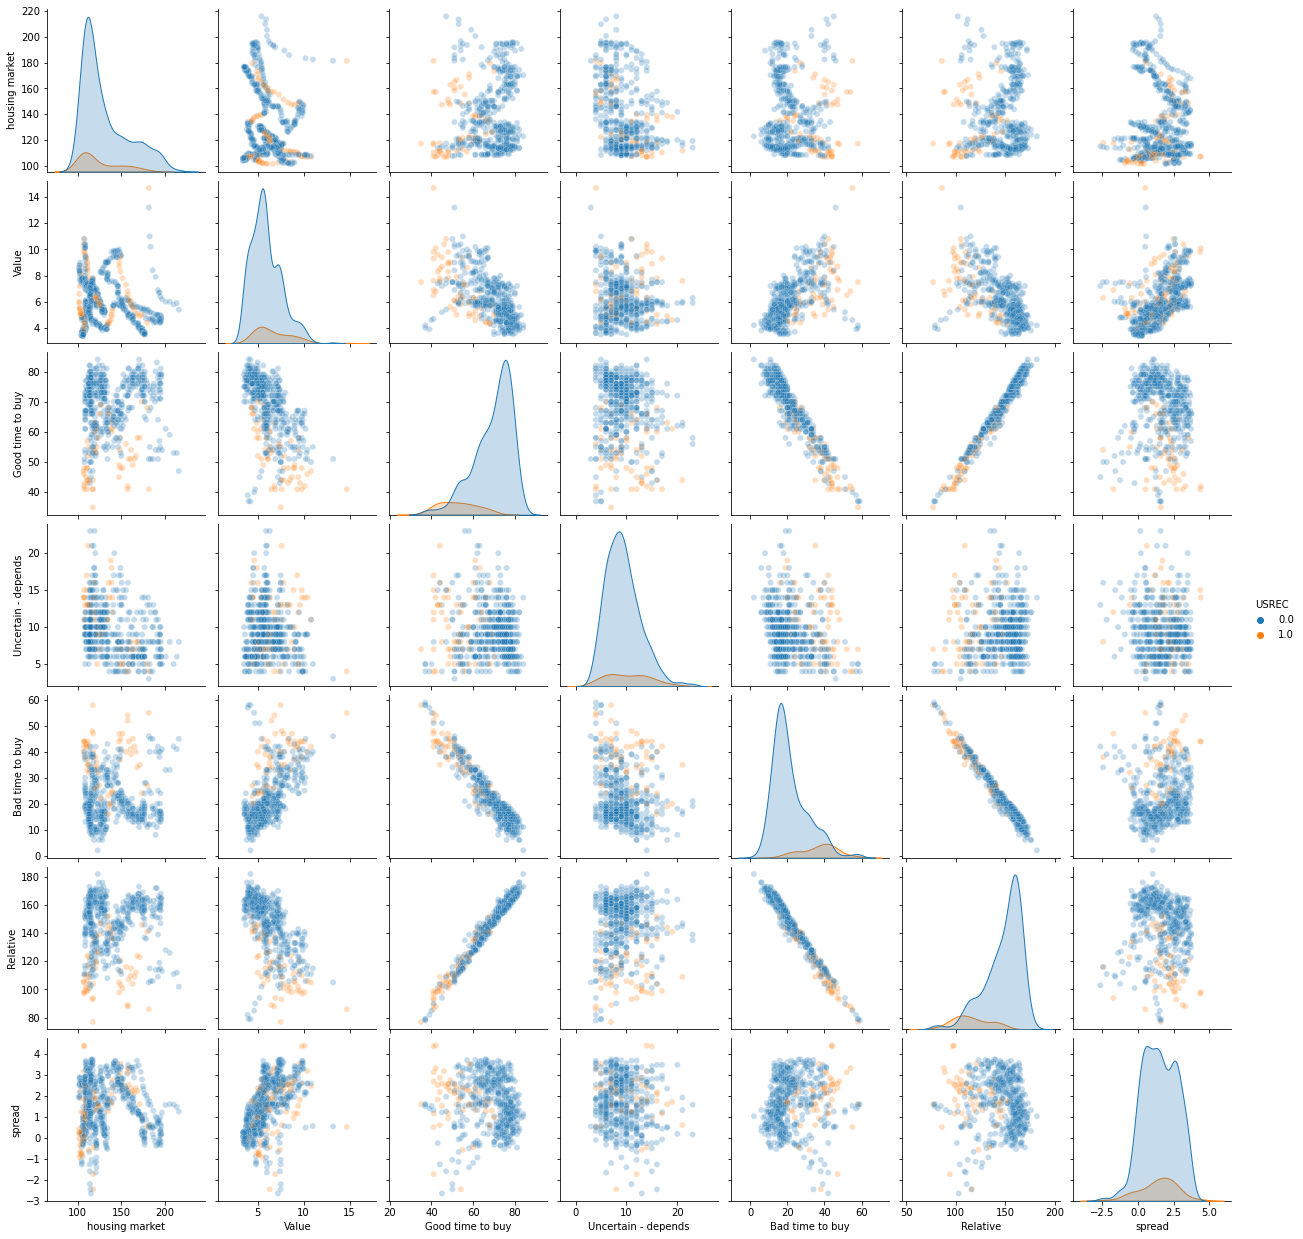

In [166]:
sns.pairplot(recession_vs_yield.drop(columns = ['Value_10yr','Value_3mon']), hue = 'USREC', plot_kws={'alpha': 0.25});

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline as smpipe
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

#Set the global X and y variables
X = data.drop(columns = ['USREC'])
y = data['USREC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [168]:
def func(X, y):
    recession_vs_yield = pd.concat([pd.DataFrame(X), pd.Series(y)], axis = 1)
    recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))
    #print(recession_vs_yield.columns)
    #Generate the different features
    data_mean = recession_vs_yield.resample('Q-JAN', convention='end').agg('mean')
    #data_mean[-1] = data_mean.iloc[:,-1].apply(lambda x: 1 if x > 0 else 0)
    data_std = recession_vs_yield.resample('Q-JAN', convention='end').agg('std').iloc[:,:-1]
    # data_max = recession_vs_yield.resample('Q-JAN', convention='end').agg('max').drop(columns = ['USREC'])
    # data_min = recession_vs_yield.resample('Q-JAN', convention='end').agg('min').drop(columns = ['USREC'])
    data_spread = recession_vs_yield.resample('Q-JAN', convention='end').agg('max') - recession_vs_yield.resample('Q-JAN', convention='end').agg('min')
    data_spread = data_spread.iloc[:,:-1].add_suffix('_split')
    print(data_mean.shape)
    #Merge them features
    data = pd.merge_asof(data_mean,data_std, left_index = True, right_index = True, suffixes = ('_mean','_std'))
    data = pd.merge_asof(data,data_spread, left_index = True, right_index = True)
    data = data.iloc[1:-1 , :]
    data.iloc[:,-1] = data.iloc[:,-1].shift(periods = -1)
    data = data.iloc[:-1,:]
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]

    return X,y

In [169]:
#Logistic regression model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', LogisticRegression(max_iter=9000))]
lr_pipe = smpipe(steps = steps)
lr_grid = [{'rgsr__C': [1e4,1e6], 'rgsr__solver': ['newton-cg', "lbfgs", 'liblinear', 'sag', 'saga']}]
lr_grid_search = GridSearchCV(estimator = lr_pipe, param_grid = lr_grid,cv = 5, scoring = 'recall')

#Random forest classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', RandomForestClassifier())]
rf_pipe = smpipe(steps = steps)
rf_grid = [{'rgsr__n_estimators': [10,50,100], 'rgsr__max_depth': range(3,30,3)}]
rf_grid_search = GridSearchCV(estimator = rf_pipe, param_grid = rf_grid, cv = 5, scoring = 'recall')

lr_grid_search.fit(X_train,y_train)
rf_grid_search.fit(X_train,y_train)
y_train_pred = lr_grid_search.predict(X_train)
y_test_pred = lr_grid_search.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.7777777777777778

In [170]:
accuracy_score(y_test,rf_grid_search.predict(X_test))

0.8611111111111112

In [171]:
lr_grid_search.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('smote', SMOTE()), ('scaler', StandardScaler()),
                ('rgsr',
                 LogisticRegression(C=1000000.0, max_iter=9000, solver='sag'))])

In [172]:
rf_grid_search.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('smote', SMOTE()), ('scaler', StandardScaler()),
                ('rgsr', RandomForestClassifier(max_depth=3, n_estimators=50))])

Area under the curve logistic regression:  0.7989
Area under the curve random forest:  0.8501


''

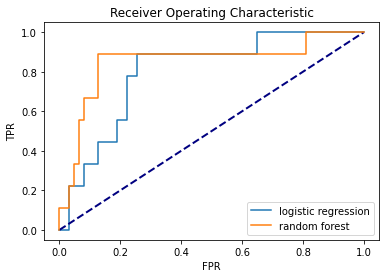

In [173]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

#For the logistic regression ROC
fpr, tpr, thresholds = roc_curve(y_test, lr_grid_search.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot(fpr,tpr, label = 'logistic regression')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characteristic')
aucscore = auc(fpr,tpr)
print('Area under the curve logistic regression: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, rf_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'random forest')
aucscore = auc(fpr,tpr)
print('Area under the curve random forest: ',round(aucscore,4))
plt.legend(loc = 'best')
;

In [174]:
y_probas = rf_grid_search.predict_proba(X_test)[:,1]
custom_thresh_y_pred_test = [1 if y > 0.5 else 0 for y in y_probas]
y_probas = lr_grid_search.predict_proba(X_train)[:,1]
custom_thresh_y_pred_train = [1 if y > 0.5 else 0 for y in y_probas]

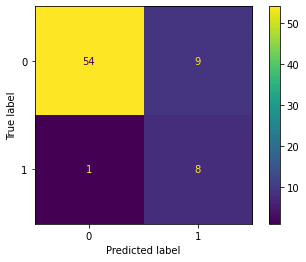

In [175]:
conf = confusion_matrix(y_test,np.array(custom_thresh_y_pred_test))
disp = ConfusionMatrixDisplay(conf)
disp.plot();

In [179]:
from sklearn.metrics import classification_report
report = classification_report(y_test,custom_thresh_y_pred_test, output_dict = True)

In [180]:
report;

(12784.0, 14610.0, 0.0, 1.0)

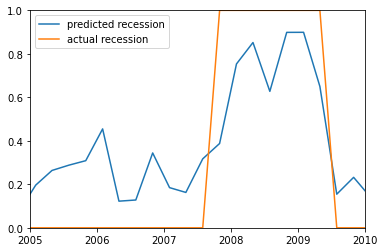

In [181]:
from datetime import datetime as dt
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')

plt.axis([dt.fromisoformat('2005-01-01'), dt.fromisoformat('2010-01-01'), 0, 1])